In [1]:
import numpy as np
import time 
import causaltensor as ct
from causaltensor import low_rank_M0_Gamma
from causaltensor.matlib import generate_Z
from causaltensor.cauest import std_debiased_convex
from causaltensor.cauest import projection_T_orthogonal
from causaltensor.cauest import tune_convex_algorithm_with_rank

## Distribution Test

Evaluate the standard deviation estimator for the debiased convex algorithm

In [2]:
def synthetic_experiment_distribution_run_results(n1 = 50, n2 = 50, mean_M = 1, r = 5, num_experiment=1, sigma = 0.1, sigma_d = 0.1, pattern = 'stagger'):
    '''
        generate (M0, Z) pair:
            - M0 has shape (50x50) with mean_M and rank r
            - Z is generated in a stagger way, randomly select m1 rows, each row randomly gets treated after column m2
            - m1 ~ [1, n1), m2 ~ [n2/5, n2) uniformly

        for each (M0, Z) pair:
            - compute the score
            -   

    '''
    samples = np.zeros(num_experiment)
    t1 = time.time()
    for T in range(num_experiment):
        if (T % 100 == 0):
            print(time.time() - t1)
            print('experiment ', T)
        #np.random.seed(1)
        M0 = low_rank_M0_Gamma(n1 = n1, n2 = n2, r = r, mean_M = mean_M)
        ## generating stagger pattern Z
        if (pattern == 'stagger'):
            m1 = np.random.randint(low=1, high=n1)
            m2 = np.random.randint(low=int(n2/2), high=n2)
            Z = generate_Z(pattern_tuple=['stagger', (m1, m2)], M0=M0)

        if (pattern == 'block'):
            m1 = np.random.randint(low=1, high=int(n1/3))
            m2 = np.random.randint(low=int(n2/2), high=n2)
            Z, treat_units = generate_Z(pattern_tuple=['block', (m1, m2)], M0=M0)

        print('***sparsity****', np.sum(Z) / np.size(Z))

        tau_star = 1

        PTperpZ = projection_T_orthogonal(Z, M0)

        # #predict_sigma = sigma / np.sqrt(np.sum(PTperpZ**2))

        predict_sigma =  np.sqrt((sigma**2) / np.sum(PTperpZ**2) + (sigma_d**2) * np.sum((PTperpZ**2)*Z) / (np.sum(PTperpZ**2)**2))

        # #print(predict_sigma, sigma / np.sqrt(np.sum(PTperpZ**2)))

        s = np.linalg.svd(M0, full_matrices=False, compute_uv=False)

        def test():
            #np.random.seed(T)
            E = np.random.normal(loc=0, scale=sigma, size=M0.shape)
            delta = np.random.normal(loc = 0, scale = sigma_d, size = M0.shape)
            O = M0 + Z * tau_star + E + delta * Z
            E_op = np.linalg.norm(E + delta * Z, ord=2)
            suggest_l = min(s[r-1]/1.1, E_op*1.1)

            #input O/predict_sigma, eliminate precision issue
            #results = run_algo(['convex_debias', 'convex'], O, Z, suggest_r = -1, suggest_l = suggest_l, eps = predict_sigma/1000, de_mean_O=False)
            
            M_debias, tau_debias, M, tau = tune_convex_algorithm_with_rank(O, Z, suggest_lambda = suggest_l, 
                                                    suggest_r=-1, de_mean_O=False, eps = predict_sigma/1000, real_data = False)

            estimated_sigma_level = std_debiased_convex(O, Z, M_debias, tau_debias, M, tau)

            return (tau_debias-tau_star)/estimated_sigma_level

            return (tau-tau_star)/predict_sigma

        # def KS_test():
        #     total = 100
        #     tau_samples = np.zeros(total)
        #     for i in range(total):
        #         tau_samples[i] = test()
        #     KS_statistic, p_value = scipy.stats.ks_1samp(tau_samples, scipy.stats.norm.cdf)
        #     print(KS_statistic, p_value)
        #     return KS_statistic

        samples[T] = test()
        print('experiment {}, time elapses {}, tau error {}'.format(T, time.time() - t1, samples[T]))
        #print(samples[T], predict_sigma)
    return samples

In [3]:
### Set up
n1 = 100
n2 = 100
mean_M = 10
r = 2
sigma = 1
sigma_d = 1

samples = synthetic_experiment_distribution_run_results(n1 = n1, n2 = n2, mean_M = mean_M, r = r, sigma = sigma, sigma_d = sigma, num_experiment = 1000, pattern = 'stagger')

9.298324584960938e-06
experiment  0
***sparsity**** 0.0024
experiment 0, time elapses 0.08133721351623535, tau error 0.39781063502585984
***sparsity**** 0.1109
experiment 1, time elapses 0.11278820037841797, tau error -0.4364480616112687
***sparsity**** 0.174
experiment 2, time elapses 0.14428424835205078, tau error -0.946978095632729
***sparsity**** 0.1766
experiment 3, time elapses 0.1795651912689209, tau error -0.25156563517497343
***sparsity**** 0.0232
experiment 4, time elapses 0.19553709030151367, tau error -1.0757079912565735
***sparsity**** 0.0207
experiment 5, time elapses 0.2140049934387207, tau error 0.278407197753639
***sparsity**** 0.1316
experiment 6, time elapses 0.24097919464111328, tau error 0.044760102589136756
***sparsity**** 0.0621
experiment 7, time elapses 0.2637779712677002, tau error 0.3852734929733978
***sparsity**** 0.0325
experiment 8, time elapses 0.28263115882873535, tau error -0.20900256234698092
***sparsity**** 0.0677
experiment 9, time elapses 0.30364203

## Distribution Plot
check whether the distribution is like Gaussian or not

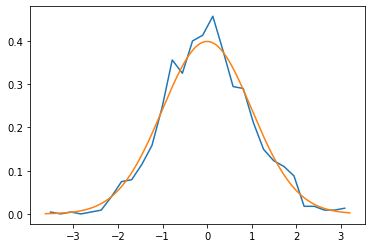

0.01083543707743295 0.9679432307496983


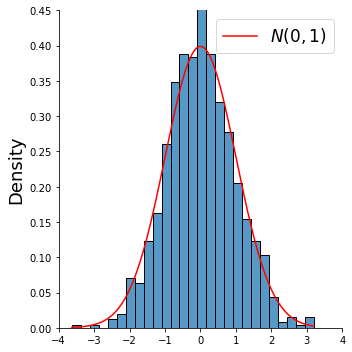

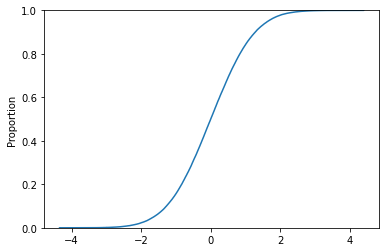

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats
import seaborn as sns

def synthetic_experiment_distribution_plot_distribution_results(samples):
    hist, bined = np.histogram(samples, bins = 30, density=True)
    plt.plot((bined[:-1]/2+bined[1:]/2), hist)
    pos_guassian = np.linspace(min(samples), max(samples), 1000)
    pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=1)
    plt.plot(pos_guassian, pdf_guassian)
    plt.show()

    print(np.mean(samples), np.std(samples))

    g = sns.displot(data=samples, kind='hist', stat='density')
    g.set(xlim=(-4, 4))
    g.set(ylim=(0.0, 0.45))
    plt.plot(pos_guassian, pdf_guassian, label=r'$N(0, 1)$', color='r')
    plt.legend(fontsize = 17)
    plt.ylabel('Density', fontsize = 18)
    plt.tight_layout()
    plt.show()
    x = scipy.stats.norm.rvs(loc=0, size=100000)
    sns.ecdfplot(data=x)
    plt.show()

synthetic_experiment_distribution_plot_distribution_results(samples)